In [1]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy import stats
from sklearn.impute import SimpleImputer
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.patheffects as path_effects
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
data = pd.read_csv('C:/Users/USER/Downloads/data.csv', sep=',', encoding='latin-1')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
# Check for missing values
missing_values = data.isnull().sum()
missing_values

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
# For simplicity, numerical columns will be filled with the median and categorical columns with the mode
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = data.select_dtypes(include=['object']).columns

for col in numerical_cols:
    data[col].fillna(data[col].median(), inplace=True)

for col in categorical_cols:
    data[col].fillna(data[col].mode()[0], inplace=True)

data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

# DATA EXPLORATION

In [6]:
# summary statistics for numerical features
data[numerical_cols].describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,541909.000000
mean,9.552250,4.611114,15253.867397
std,218.081158,96.759853,1485.905852
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,14367.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16255.000000
max,80995.000000,38970.000000,18287.000000


In [7]:
#summary statistics for categorical features
data[categorical_cols].describe()

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,541909,541909,541909,541909,541909
unique,25900,4070,4223,23260,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,10/31/2011 14:41,United Kingdom
freq,1114,2313,3823,1114,495478


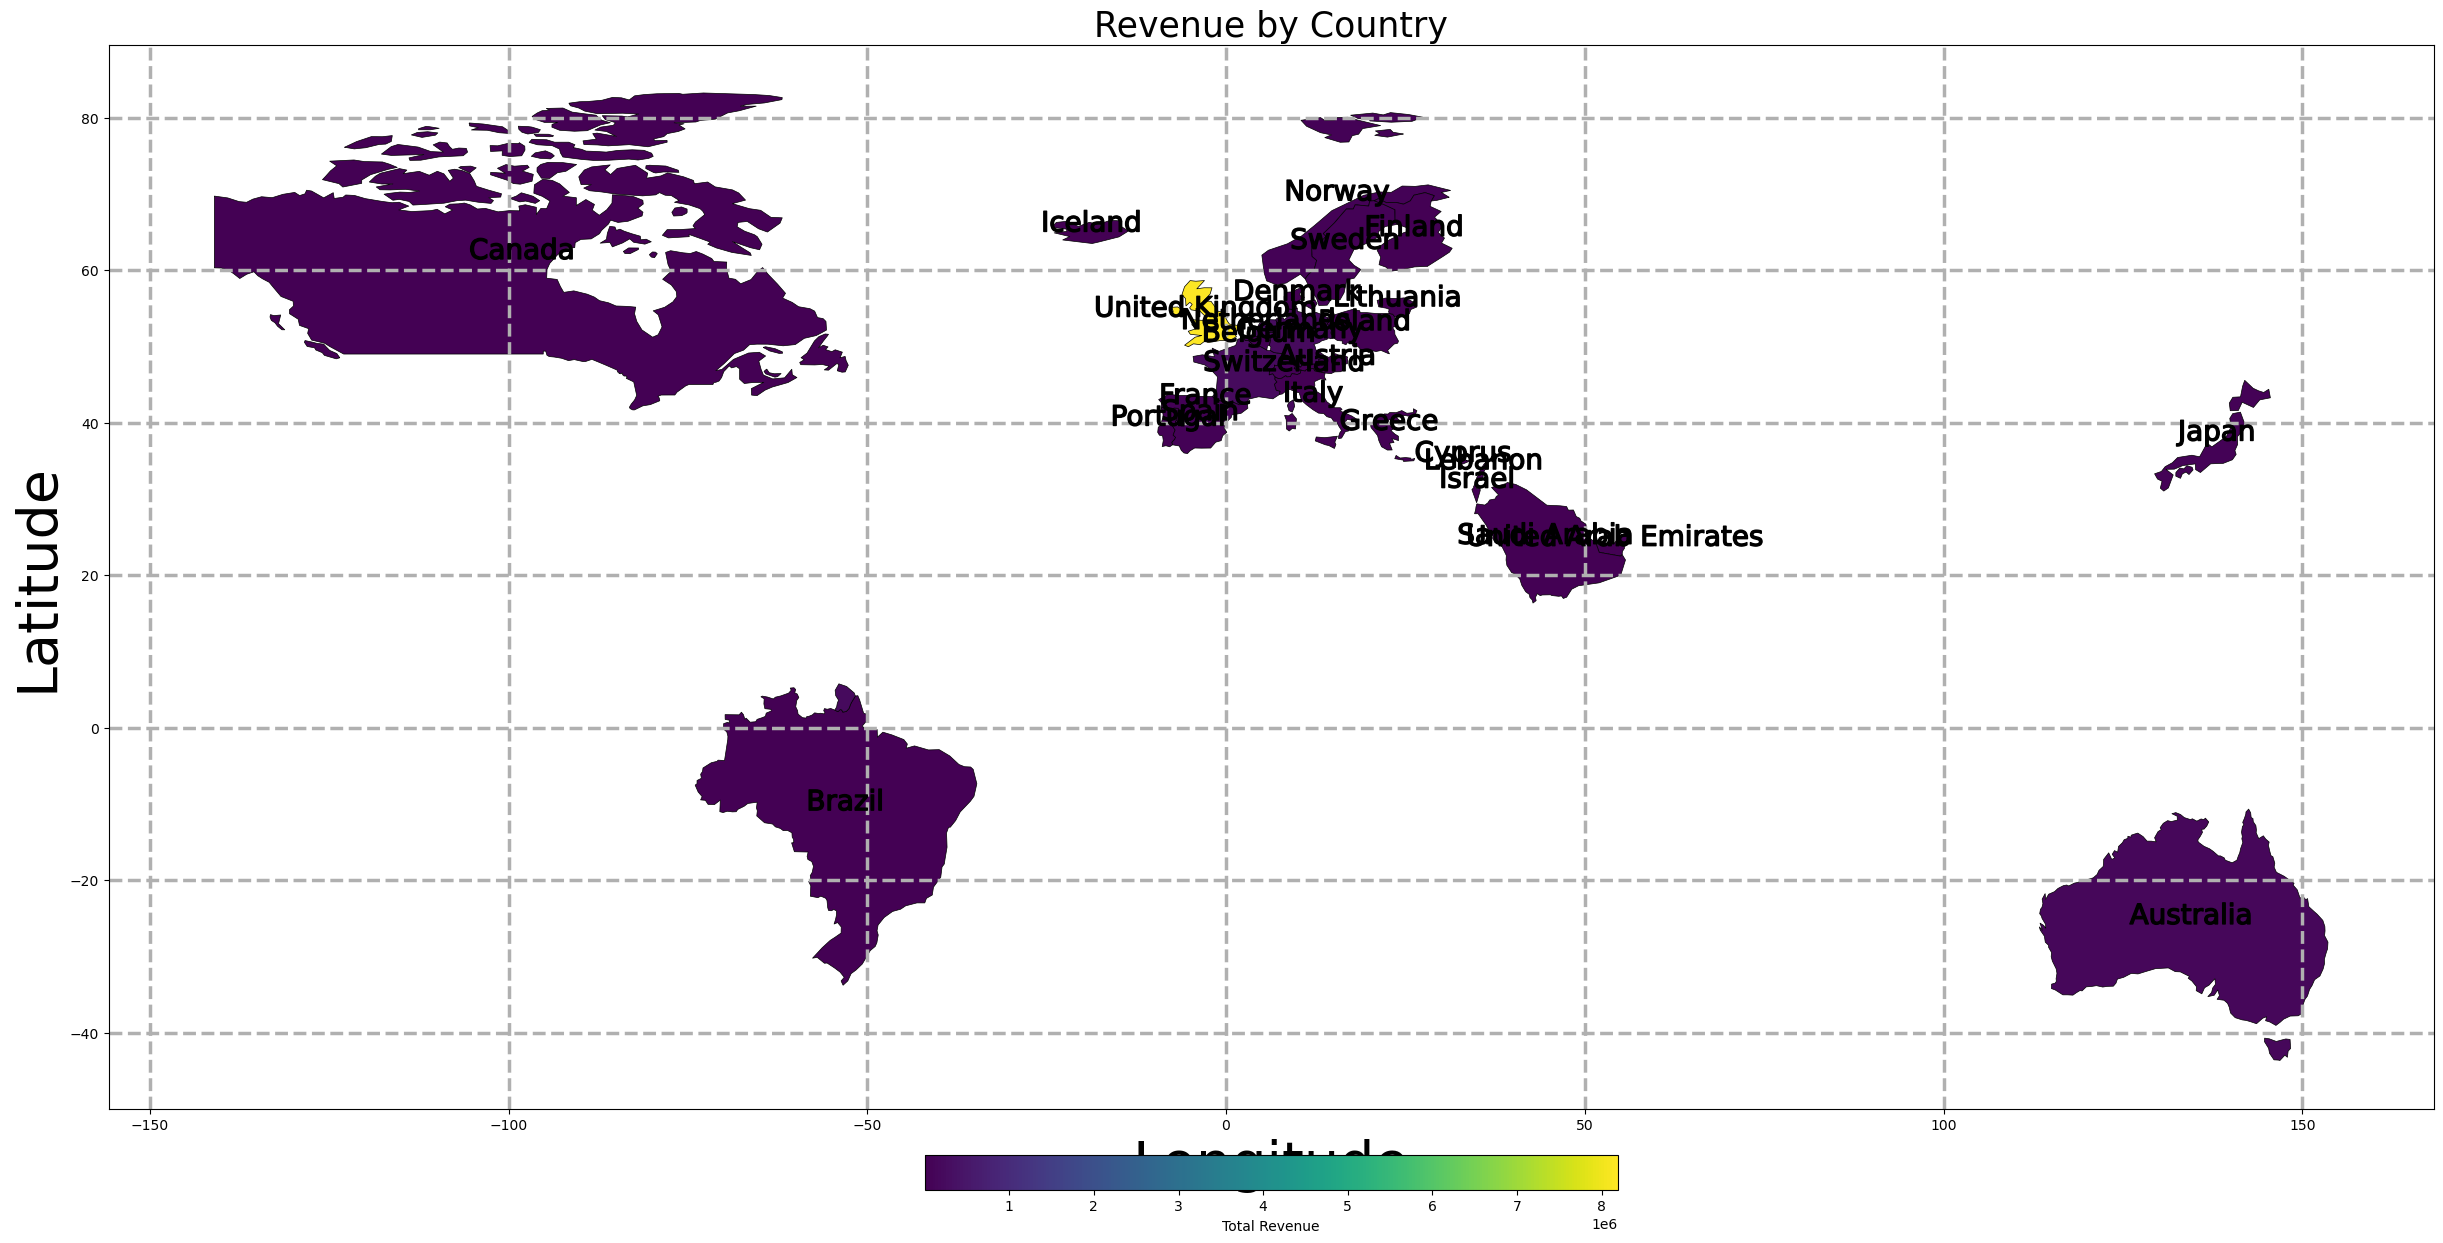

In [8]:
# Create TotalPrice column
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

# Calculate revenue by country
revenue_by_country = data.groupby('Country')['TotalPrice'].sum().reset_index()

# Load world shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge revenue data with world shapefile
world = world.merge(revenue_by_country, how='left', left_on='name', right_on='Country')

# Filter out countries not in the dataset
world = world[world['TotalPrice'].notnull()]

# Plot choropleth map
fig, ax = plt.subplots(1, 1, figsize=(30, 15))  # Increase the size of the map
norm = mcolors.Normalize(vmin=world['TotalPrice'].min(), vmax=world['TotalPrice'].max())
cmap = plt.cm.viridis
world.plot(column='TotalPrice', ax=ax, legend=False, cmap=cmap, edgecolor='black', linewidth=0.5, missing_kwds={'color': 'lightgrey'})

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", fraction=0.03, pad=0.04, label='Total Revenue')

for x, y, label in zip(world.geometry.centroid.x, world.geometry.centroid.y, world['name']):
    ax.text(x, y, label, fontsize=20, ha='center', color='black', path_effects=[path_effects.withStroke(linewidth=1, foreground="black")])

ax.set_title('Revenue by Country', fontsize=25)
ax.set_xlabel('Longitude', fontsize=40)
ax.set_ylabel('Latitude', fontsize=40)
ax.grid(True, linestyle='--', linewidth=2.5)

plt.show()


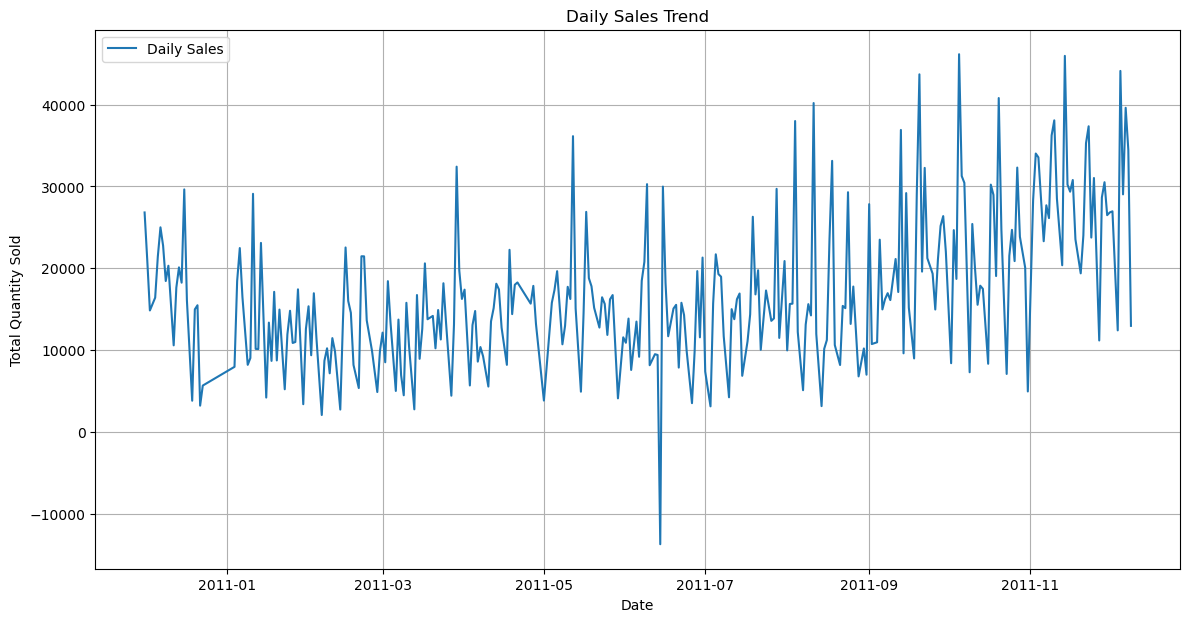

In [9]:
#sales trend analysis

# Convert InvoiceDate to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Group by date to get daily sales
daily_sales = data.groupby(data['InvoiceDate'].dt.date)['Quantity'].sum().reset_index()
daily_sales.columns = ['Date', 'TotalQuantity']

plt.figure(figsize=(14, 7))
plt.plot(daily_sales['Date'], daily_sales['TotalQuantity'], label='Daily Sales')
plt.title('Daily Sales Trend')
plt.xlabel('Date')
plt.ylabel('Total Quantity Sold')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# inventory optimization

# Calculate daily sales for each product
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
daily_sales = data.groupby([data['InvoiceDate'].dt.date, 'StockCode'])['Quantity'].sum().reset_index()
daily_sales.columns = ['Date', 'StockCode', 'DailyQuantity']

# Calculate average daily sales and standard deviation for each product
inventory_stats = daily_sales.groupby('StockCode')['DailyQuantity'].agg(['mean', 'std']).reset_index()
inventory_stats.columns = ['StockCode', 'AvgDailySales', 'SalesStdDev']

# Calculate reorder point (assuming lead time of 7 days and service level of 95%)
service_level = 1.65  # Corresponds to 95% service level
lead_time = 7
inventory_stats['ReorderPoint'] = inventory_stats['AvgDailySales'] * lead_time + service_level * inventory_stats['SalesStdDev']

inventory_stats.head()


,StockCode,AvgDailySales,SalesStdDev,ReorderPoint
0,10002,21.604167,36.631424,211.671017
1,10080,22.500000,37.249161,218.961116
2,10120,8.041667,10.178747,73.086599
3,10123C,-3.250000,9.878428,-6.450594
4,10123G,-38.000000,NaN,NaN


###### Conclusion:

For products like StockCode 10002 and 10080 with high sales variability, maintaining a higher reorder point is essential to avoid stockouts. Regular monitoring and adjustment based on sales trends are recommended.

The negative average daily sales for StockCode 10123C and 10123G indicate potential data entry errors or returns. These anomalies should be investigated and corrected to ensure accurate inventory management.



#                                    MARKET BASKET ANALYSIS

In [11]:
# Preprocess data for market basket analysis
basket = (data.groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

# Convert quantities to binary values (1 for purchased, 0 for not purchased)
basket = basket.applymap(lambda x: 1 if x > 0 else 0).astype(bool)

# Filter out columns with all zeros
basket = basket.loc[:, (basket != 0).any(axis=0)]

# Reduce the dataset size by filtering infrequent items before applying apriori
min_item_support = 0.01 
item_support = basket.sum() / len(basket)
frequent_items = item_support[item_support >= min_item_support].index
basket = basket[frequent_items]

# Generate frequent itemsets with a higher min_support to reduce memory usage
frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True, low_memory=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Print the rules
rules


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(60 CAKE CASES VINTAGE CHRISTMAS),(PAPER CHAIN KIT 50'S CHRISTMAS ),0.023861,0.044788,0.010463,0.438511,9.790899,0.009395,1.701214,0.919812
1,(PAPER CHAIN KIT 50'S CHRISTMAS ),(60 CAKE CASES VINTAGE CHRISTMAS),0.044788,0.023861,0.010463,0.233621,9.790899,0.009395,1.273702,0.939963
2,(SET OF 20 VINTAGE CHRISTMAS NAPKINS),(60 CAKE CASES VINTAGE CHRISTMAS),0.023552,0.023861,0.010425,0.442623,18.550056,0.009863,1.751308,0.968912
3,(60 CAKE CASES VINTAGE CHRISTMAS),(SET OF 20 VINTAGE CHRISTMAS NAPKINS),0.023861,0.023552,0.010425,0.436893,18.550056,0.009863,1.734037,0.969218
4,(72 SWEETHEART FAIRY CAKE CASES),(60 TEATIME FAIRY CAKE CASES),0.023745,0.031969,0.010695,0.450407,14.088802,0.009936,1.761358,0.951618
...,...,...,...,...,...,...,...,...,...,...
1205,"(JUMBO SHOPPER VINTAGE RED PAISLEY, JUMBO STOR...","(JUMBO BAG PINK POLKADOT, JUMBO BAG RED RETROS...",0.020232,0.031853,0.010347,0.511450,16.056442,0.009703,1.981675,0.957083
1206,(JUMBO BAG PINK POLKADOT),"(JUMBO BAG RED RETROSPOT, JUMBO SHOPPER VINTAG...",0.047027,0.015058,0.010347,0.220033,14.612437,0.009639,1.262799,0.977536
1207,(JUMBO BAG RED RETROSPOT),"(JUMBO BAG PINK POLKADOT, JUMBO SHOPPER VINTAG...",0.080772,0.011931,0.010347,0.128107,10.737777,0.009384,1.133246,0.986557
1208,(JUMBO SHOPPER VINTAGE RED PAISLEY),"(JUMBO BAG PINK POLKADOT, JUMBO BAG RED RETROS...",0.045367,0.015946,0.010347,0.228085,14.303642,0.009624,1.274822,0.974288


In [29]:
# Identify the top 5 most frequently purchased items
top_5_items = data['StockCode'].value_counts().nlargest(5).index

# Filter the dataset for only the top 5 items
df_top_5 = data[data['StockCode'].isin(top_5_items)]

# Prepare the data for market basket analysis
basket = df_top_5.groupby(['InvoiceNo', 'StockCode'])['Quantity'].sum().unstack().fillna(0)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

# Generate frequent itemsets
frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Map StockCode to Description
stockcode_to_description = data[['StockCode', 'Description']].drop_duplicates().set_index('StockCode')['Description'].to_dict()

# Add antecedent and consequent descriptions to the rules dataframe
rules['antecedents_desc'] = rules['antecedents'].apply(lambda x: [stockcode_to_description[item] for item in x])
rules['consequents_desc'] = rules['consequents'].apply(lambda x: [stockcode_to_description[item] for item in x])

# Print descriptions of top 5 items
print("\nDescriptions of Top 5 Most Frequently Purchased Items:")
for item in top_5_items:
    description = data[data['StockCode'] == item]['Description'].iloc[0]
    print(f"StockCode: {item}, Description: {description}")



Descriptions of Top 5 Most Frequently Purchased Items:
StockCode: 85123A, Description: WHITE HANGING HEART T-LIGHT HOLDER
StockCode: 22423, Description: REGENCY CAKESTAND 3 TIER
StockCode: 85099B, Description: JUMBO BAG RED RETROSPOT
StockCode: 47566, Description: PARTY BUNTING
StockCode: 20725, Description: LUNCH BAG RED RETROSPOT


In [35]:
# Identify the top 5 most frequently purchased items
top_5_items = data['StockCode'].value_counts().nlargest(5).index

# Filter the dataset for only the top 5 items
df_top_5 = data[data['StockCode'].isin(top_5_items)]

# Prepare the data for market basket analysis
basket = df_top_5.groupby(['InvoiceNo', 'StockCode'])['Quantity'].sum().unstack().fillna(0)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

# Generate frequent itemsets
frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Map StockCode to Description
stockcode_to_description = data[['StockCode', 'Description']].drop_duplicates().set_index('StockCode')['Description'].to_dict()

# Add antecedent and consequent descriptions to the rules dataframe
rules['antecedents_desc'] = rules['antecedents'].apply(lambda x: [stockcode_to_description[item] for item in x])
rules['consequents_desc'] = rules['consequents'].apply(lambda x: [stockcode_to_description[item] for item in x])

# Filter rules where antecedents contain any of the top 5 items
top_5_rules = rules[rules['antecedents'].apply(lambda x: any(item in top_5_items for item in x))]

# Sort by confidence and lift to get the top 5 product pairs
top_5_rules = top_5_rules.sort_values(by=['confidence', 'lift'], ascending=False).head(5)

# Print top product recommendations with descriptions
print("Top Product Recommendations:")
print(top_5_rules[['antecedents', 'antecedents_desc', 'consequents', 'consequents_desc', 'support', 'confidence', 'lift']])

# Print descriptions of top 5 items
print("\nDescriptions of Top 5 Most Frequently Purchased Items:")
for item in top_5_items:
    description = data[data['StockCode'] == item]['Description'].iloc[0]
    print(f"StockCode: {item}, Description: {description}")


Top Product Recommendations:
        antecedents                                   antecedents_desc  \
2    (22423, 20725)                    [damages, LUNCH BAG RED SPOTTY]   
26  (20725, 85123A)  [LUNCH BAG RED SPOTTY, CREAM HANGING HEART T-L...   
8    (22423, 20725)                    [damages, LUNCH BAG RED SPOTTY]   
4    (20725, 47566)              [LUNCH BAG RED SPOTTY, PARTY BUNTING]   
9   (22423, 85099B)                 [damages, JUMBO BAG RED RETROSPOT]   

   consequents           consequents_desc   support  confidence      lift  
2      (47566)            [PARTY BUNTING]  0.018656    0.480144  2.030219  
26    (85099B)  [JUMBO BAG RED RETROSPOT]  0.021041    0.454545  1.548974  
8     (85099B)  [JUMBO BAG RED RETROSPOT]  0.016272    0.418773  1.427070  
4      (22423)                  [damages]  0.018656    0.416928  1.494358  
9      (20725)     [LUNCH BAG RED SPOTTY]  0.016272    0.405594  1.847593  

Descriptions of Top 5 Most Frequently Purchased Items:
StockCode: 851

## Top Product Recommendations:

#### Antecedents (Products bought together)
#### Consequent (Product often bought with the antecedent
#### Rule :The confidence of 48% indicates that nearly half of the transactions that included the antecedents also included the consequent.  The lift of 2.03 means that the consequent is 2.03 times more likely to be bought when the antecedents are bought compared to being bought independently.

#### Interpretation
Customers who bought "LUNCH BAG RED SPOTTY" and "CREAM HANGING HEART T-LIGHT HOLDER" together also bought "JUMBO BAG RED RETROSPOT". The confidence of 45% indicates that nearly half of the transactions that included the antecedents also included the consequent. 

Customers who bought "LUNCH BAG RED SPOTTY" also bought "JUMBO BAG RED RETROSPOT".

Customers who bought "JUMBO BAG RED RETROSPOT" also bought "LUNCH BAG RED SPOTTY".

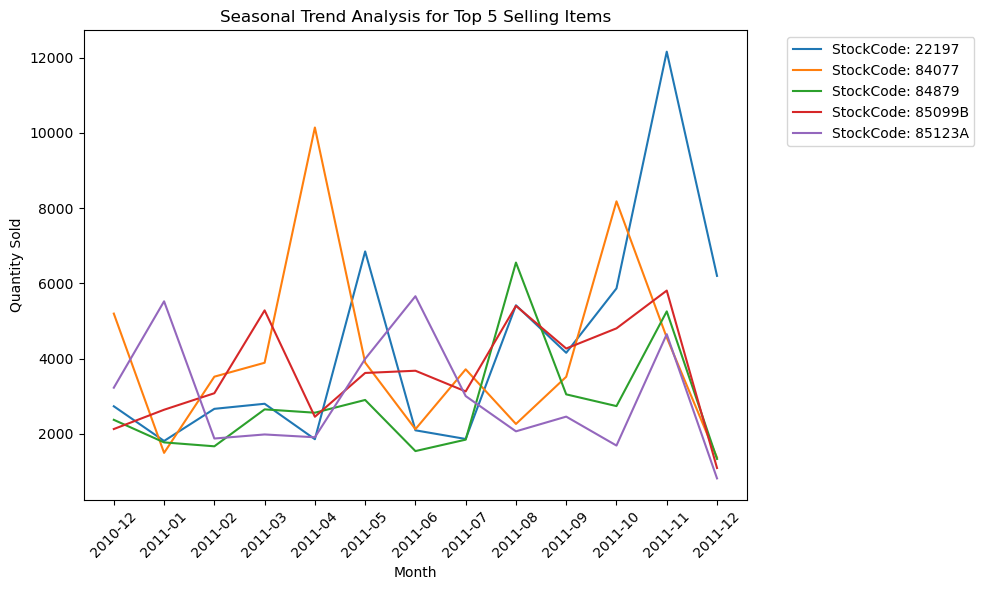

In [21]:
# Convert InvoiceDate to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Extract month and year from InvoiceDate
data['Month'] = data['InvoiceDate'].dt.to_period('M')

# Identify the top 5 selling StockCodes
top_5_stock_codes = data.groupby('StockCode')['Quantity'].sum().nlargest(5).index

# Filter the data for only the top 5 selling StockCodes
data_top_5 = data[data['StockCode'].isin(top_5_stock_codes)]

# Aggregate sales by month and stock code for the top 5 StockCodes
monthly_sales_top_5 = data_top_5.groupby(['Month', 'StockCode'])['Quantity'].sum().reset_index()

# Reduce figure size and increase DPI
plt.figure(figsize=(10, 6), dpi=100)

# Plot seasonal trends for each of the top 5 StockCodes
for stock_code in monthly_sales_top_5['StockCode'].unique():
    subset = monthly_sales_top_5[monthly_sales_top_5['StockCode'] == stock_code]
    plt.plot(subset['Month'].astype(str), subset['Quantity'], label=f'StockCode: {stock_code}')

plt.title('Seasonal Trend Analysis for Top 5 Selling Items')
plt.xlabel('Month')
plt.ylabel('Quantity Sold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


#### The line graph shows the quantity sold over time (from December 2010 to December 2011) for the top 5 selling items, identified by their StockCode. Each line represents the monthly sales quantity of one of these items.

### StockCode 22197:

Sales fluctuate throughout the year with noticeable peaks in April and October and with significant drop-off in December 2011.

### StockCode 84077:

This item shows a dramatic peak in April as well

### StockCode 84879:

Sales are quite variable, with a significant peak in April and smaller peaks in September and October.

### StockCode 85099B:

This item has steady sales with peaks in February, April, and October.

### StockCode 85123A:

The item has a peak in January and fluctuates moderately throughout the year.

### Conclusion:

1. Several items had peaks in April, indicating seasonal demand.
2. October also seems to be a high sales month for multiple items, suggesting another period of increased demand.
3. Items like StockCode 85099B have more consistent sales throughout the year
4. There is need for careful inventory management, particularly before and after peak sales months to avoid stockouts or excess inventory.
5. Increase marketing efforts and promotions in April and October for the top-selling items to maximize sales during these high-demand periods.
6. Investigate the factors contributing to the high sales in April and October to better understand and replicate these trends for other products.

In [37]:
from scipy.sparse import csr_matrix

# Convert the data into the right format
basket = data.groupby(['InvoiceNo', 'StockCode'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')
basket_sparse = csr_matrix(basket.applymap(lambda x: 1 if x > 0 else 0))

# Generate frequent itemsets with a higher min_support
frequent_itemsets = apriori(pd.DataFrame.sparse.from_spmatrix(basket_sparse, columns=basket.columns), min_support=0.02, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Sort by lift and get top 5 pairs
top_5_pairs = rules.sort_values(by='lift', ascending=False).head(5)

# Map StockCode to Description
stockcode_to_description = data[['StockCode', 'Description']].drop_duplicates().set_index('StockCode')['Description'].to_dict()

# Add descriptions to the top 5 pairs
top_5_pairs['antecedents_desc'] = top_5_pairs['antecedents'].apply(lambda x: [stockcode_to_description[item] for item in x])
top_5_pairs['consequents_desc'] = top_5_pairs['consequents'].apply(lambda x: [stockcode_to_description[item] for item in x])

print("Top 5 Product Pairs with Descriptions:")
print(top_5_pairs[['antecedents', 'antecedents_desc', 'consequents', 'consequents_desc', 'support', 'confidence', 'lift']])


Top 5 Product Pairs with Descriptions:
       antecedents                                   antecedents_desc  \
68         (22698)               [WHITE HANGING HEART T-LIGHT HOLDER]   
65  (22699, 22697)  [ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...   
64  (22699, 22698)  [ROSES REGENCY TEACUP AND SAUCER , WHITE HANGI...   
69         (22697)                  [GREEN REGENCY TEACUP AND SAUCER]   
47         (22697)                  [GREEN REGENCY TEACUP AND SAUCER]   

       consequents                                   consequents_desc  \
68  (22699, 22697)  [ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...   
65         (22698)               [WHITE HANGING HEART T-LIGHT HOLDER]   
64         (22697)                  [GREEN REGENCY TEACUP AND SAUCER]   
69  (22699, 22698)  [ROSES REGENCY TEACUP AND SAUCER , WHITE HANGI...   
47         (22698)               [WHITE HANGING HEART T-LIGHT HOLDER]   

     support  confidence       lift  
68  0.020927    0.707572  23.862122  
65  0.0

##### The result shows the top 5 product pairs frequently bought together, based on association rule.

Pair 1:
When customers buy the WHITE HANGING HEART T-LIGHT HOLDER, there is a high likelihood (70.76%) they will also buy both the ROSES and GREEN REGENCY TEACUP AND SAUCER.

Pair 2:
Customers purchasing both the ROSES and GREEN REGENCY TEACUP AND SAUCER are very likely (70.57%) to also buy the WHITE HANGING HEART T-LIGHT HOLDER.

Pair 3:
When both the ROSES REGENCY TEACUP AND SAUCER and WHITE HANGING HEART T-LIGHT HOLDER are purchased, there is a very high likelihood (90.48%) that customers will also buy the GREEN REGENCY TEACUP AND SAUCER.

Pair 4:
When customers buy the GREEN REGENCY TEACUP AND SAUCER, there is a 53.40% chance they will also buy both the ROSES REGENCY TEACUP AND SAUCER and WHITE HANGING HEART T-LIGHT HOLDER.

Pair 5:
Customers who purchase the GREEN REGENCY TEACUP AND SAUCER have a 62.36% likelihood of also buying the WHITE HANGING HEART T-LIGHT HOLDER.

##    Conclusion:

1. The WHITE HANGING HEART T-LIGHT HOLDER is a common item in many pairs, suggesting it is a popular complementary product for the REGENCY TEACUP AND SAUCER sets.

2. Retailers can consider bundling these frequently bought-together items as a promotional offer to boost sales. For example, offering a discount on the WHITE HANGING HEART T-LIGHT HOLDER when purchased with the REGENCY TEACUP AND SAUCER sets.
